In [2]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')
import pickle


import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, mean_squared_error

from technicalSignals import Indicators




#CPU RUN
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
kind_of_dataset = 'Summary'
NN_INPUT_DIM = 66

In [4]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)


        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                                  'SMA_30','SMA_50','SMA_100','SMA_150','in_BBands','eccessVolumes']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        with open('min_max_scaler_trained_allTickers_VolumeFeature.pickle', 'rb') as handle:
            min_max_scaler = pickle.load(handle)
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(cumulative_return)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
        
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    
    def get_dataset_for_trend_all_tickers(self, init, finish,kind, perc_train = 0.7, technicalFeatures=False):
        x_tv_all = []
        y_tv_all = []
        x_test_all = []
        y_test_all = []
        dates_test_prev = None
        for ticker in tickers:
            self.load_dataset(ticker, kind, technicalFeatures)
            (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
            if(dates_test_prev):
                assert dates_test == dates_test_prev #I'm not secure about this constraint but otherwise which dates I will output?
            x_tv_all += x_tv.tolist()
            y_tv_all += y_tv.tolist()
            x_test_all += x_test.tolist()
            y_test_all += y_test.tolist()
        x_tv_all = np.asarray(x_tv_all)
        y_tv_all = np.asarray(y_tv_all)
        x_test_all = np.asarray(x_test_all)
        y_test_all = np.asarray(y_test_all)
        return (x_tv_all,y_tv_all),(x_test_all,y_test_all), dates_test

In [5]:
def weighted_MSE(y_true, y_pred):
    weights = K.pow(y_true,2)
    m = K.min(weights)
    M = K.max(weights)
    weights = (weights-m)/(M-m)
    return  K.mean(K.pow(y_true - y_pred, 2)*weights)

def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units / (1 - dropout))
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
    model.add(BatchNormalization()) # Batch norm applied only on the part without activation (done more often)
    model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='tanh')) 
    #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) OFFICIAL
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
    return model

def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,y_pred,y_test,l2,drop,n_units):
    f, axarr = plt.subplots(2)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(y_test,'g', label='y_test')
    axarr[0].plot(y_pred,'r', label='y_pred')
    axarr[1].semilogy(history.history['loss'],'g--',label='loss_train')
    axarr[1].semilogy(history.history['val_loss'],'r--',label='loss_val')
    axarr[1].semilogy(history.history['val_weighted_MSE'],'b:',label='loss_val_WITH_W')
    axarr[1].semilogy(history.history['weighted_MSE'],'g:',label='loss_WITH_W')
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('l2: '+str(l2)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show()
    print('Min val loss: ', min(history.history['val_loss']))
    print('Val loss: ', history.history['val_loss'][-1])
            
            
def cv(x_tv,y_tv):
    max_norm_space=[3, 5, 10, 30]
    drop_space=[0.5]
    n_unit_space=[4, 8, 16, 32]
    best_mse = float(np.inf)
    best_max_norm = 0
    best_drop = 0
    best_n_units = 0
    best_epochs = 0
    for max_norm in max_norm_space:
        for drop in drop_space:
            for n_units in n_unit_space:
                print('.', end='')
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                #Cross validation
                cvMSE = 0
                nn_model = buildNN2(n_expected_active_units=n_units, dropout = drop, max_norm_val = max_norm)
                epochs = 0
                for i in range(0,4):
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    weights = np.power(y_train,2)
                    m = min(weights)
                    M = max(weights)
                    weights = (weights-m)/(M-m)
                    history = nn_model.fit(x_train, y_train, epochs = 1000,batch_size =256, verbose=0, 
                                           validation_data=(x_val, y_val),shuffle=True,
                                           sample_weight = weights)
                    mse = min(history.history['val_weighted_MSE'])
                    epochs = max(np.argmin(history.history['val_weighted_MSE']),600)
                    y_pred = nn_model.predict(x_val, batch_size=256, verbose=0)
                    cvMSE += mse/4
                    reset_weights(nn_model)
                if(cvMSE < best_mse):
                    best_mse = cvMSE
                    best_max_norm = max_norm
                    best_drop = drop
                    best_n_units = n_units
                    best_epochs = epochs
                
    return (best_max_norm,best_drop,best_n_units,best_epochs)




model_selection =  {
    (-48,0):(30, 0.5, 32, 417),
    (-35,0):(3, 0.5, 32, 902),
    (-28,0):(30, 0.5, 32, 737),
    (-7,0):(3, 0.5, 32, 948),
    (-1, 0): (3, 0.5, 32, 900),
    (1, 2): (10, 0.5, 8, 600),
    (1, 8): (10, 0.5, 16, 600),
     (1, 29): (3, 0.5, 4, 600),
     (1, 36): (5, 0.5, 8, 600),
    (1, 50): (10, 0.5, 16, 600)
}

model_selection =  {}





====================  trend:  -48   0  ==================== 


................(3, 0.5, 32, 999)
==== Test ===


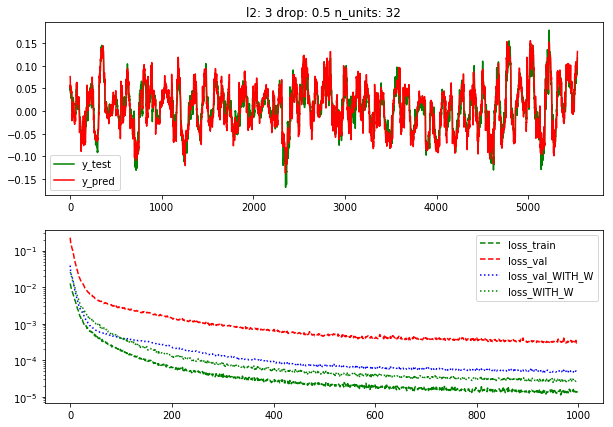

Min val loss:  0.000295349702765217
Val loss:  0.0003047228188569984



====================  trend:  -35   0  ==================== 


................(3, 0.5, 32, 978)
==== Test ===


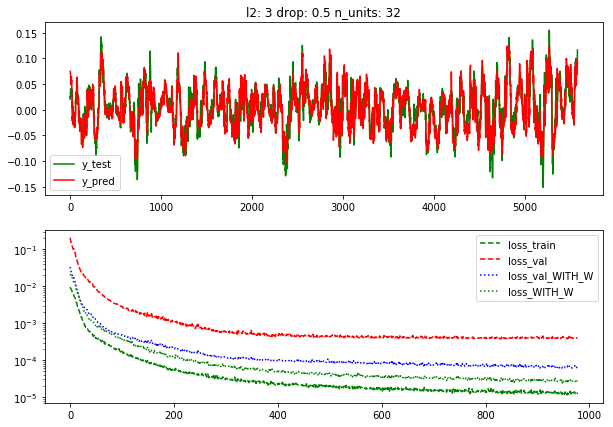

Min val loss:  0.0003773404390669651
Val loss:  0.00038495529651655196



====================  trend:  -28   0  ==================== 


................(3, 0.5, 32, 888)
==== Test ===


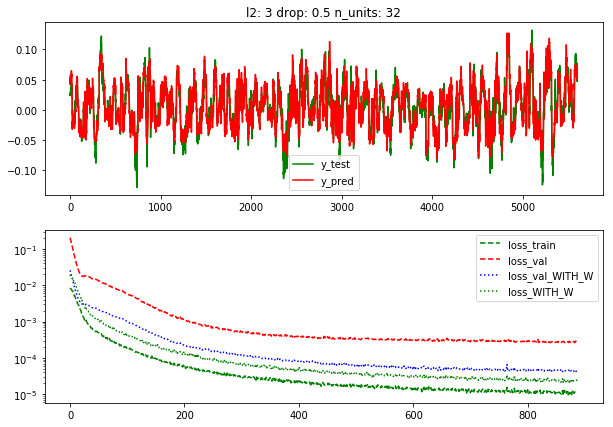

Min val loss:  0.0002623378746544144
Val loss:  0.000277608731329175



====================  trend:  -7   0  ==================== 


................(30, 0.5, 32, 997)
==== Test ===


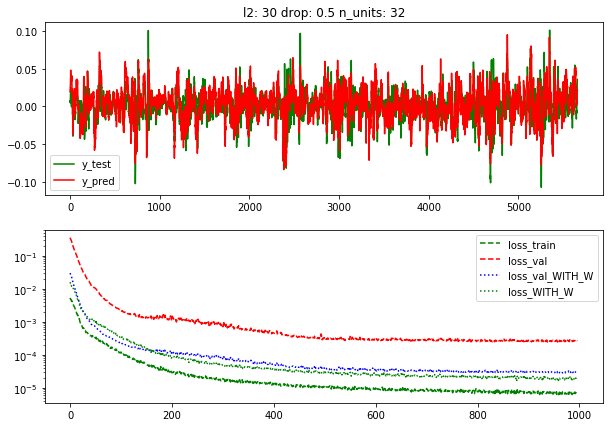

Min val loss:  0.00024305999336818516
Val loss:  0.0002653784552784867



====================  trend:  -1   0  ==================== 


................(10, 0.5, 32, 849)
==== Test ===


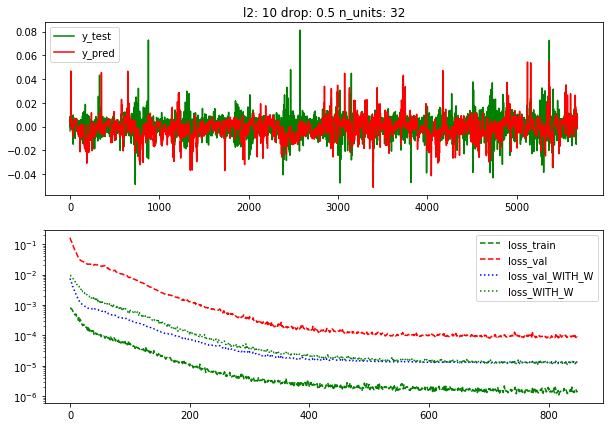

Min val loss:  8.105244188287466e-05
Val loss:  9.181378720800432e-05



====================  trend:  1   2  ==================== 


................(10, 0.5, 4, 600)
==== Test ===


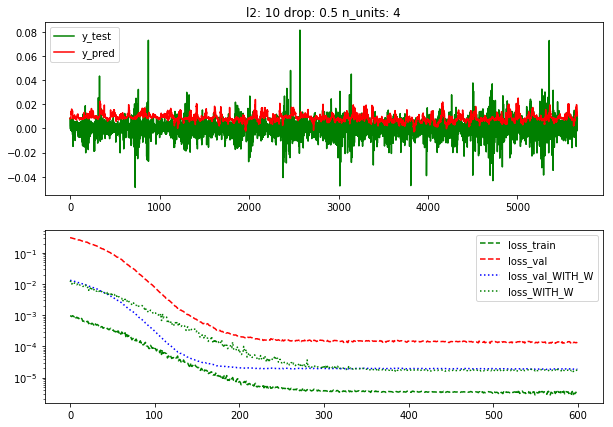

Min val loss:  0.00012635419631984194
Val loss:  0.0001306596548348662



====================  trend:  1   8  ==================== 


................(30, 0.5, 8, 600)
==== Test ===


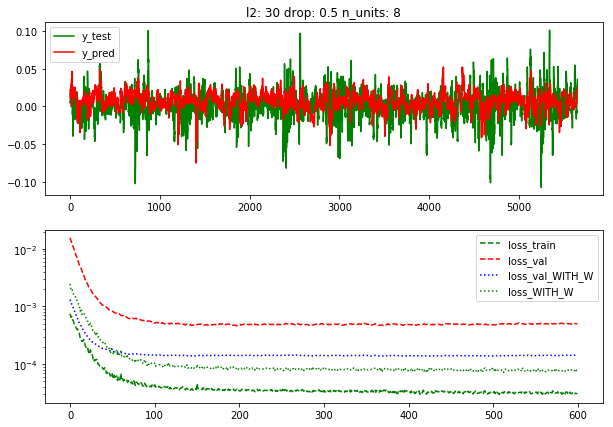

Min val loss:  0.0004617669740568154
Val loss:  0.0004998655267707813



====================  trend:  1   29  ==================== 


................(10, 0.5, 8, 600)
==== Test ===


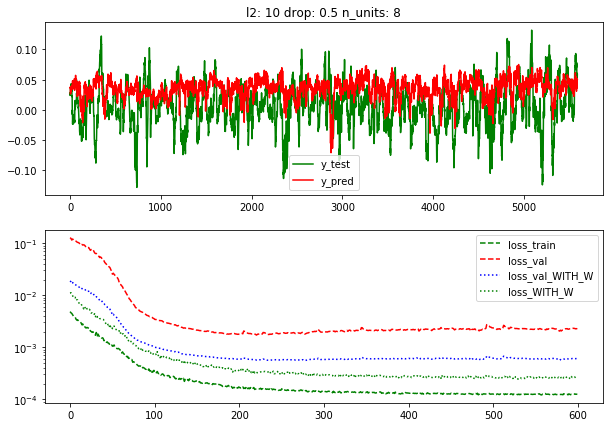

Min val loss:  0.0017140268141358811
Val loss:  0.002260638226310128



====================  trend:  1   36  ==================== 


................(30, 0.5, 4, 600)
==== Test ===


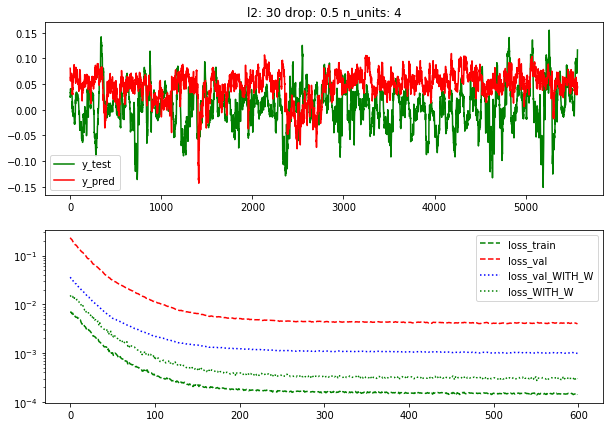

Min val loss:  0.003963082118329376
Val loss:  0.003963082118329376



====================  trend:  1   50  ==================== 


................(10, 0.5, 4, 600)
==== Test ===


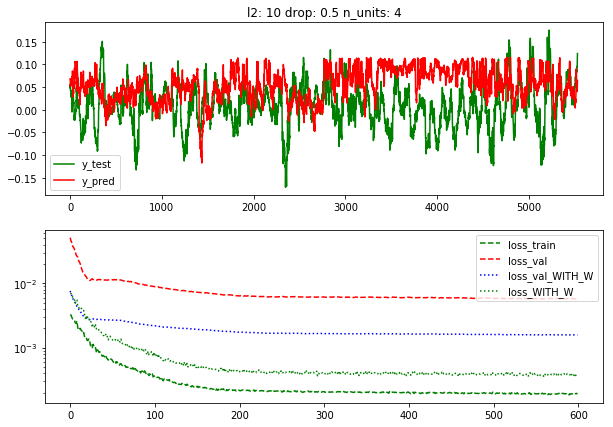

Min val loss:  0.005726293965758988
Val loss:  0.00573863664875228


In [6]:
# ALL TICKERS
#Load results stored
if(os.path.isfile('model_selection_info_volumeFeature.pickle')):
    with open('model_selection_info_volumeFeature.pickle', 'rb') as handle:
        model_selection_results = pickle.load(handle)
else:
    model_selection_results = {}

for (init, finish) in TREND_WINDOWs:
    print('\n\n\n====================  trend: ',init,' ',finish, ' ==================== \n\n')
    
    ds = DatasetManager()
    (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend_all_tickers(init,finish,kind_of_dataset,perc_train=0.7,technicalFeatures=True)
    if (init, finish) in model_selection_results:
        (best_l2,best_drop,best_n_units,best_epochs) = model_selection_results[(init, finish)]
    else:
        (best_l2,best_drop,best_n_units,best_epochs) = cv(x_tv,y_tv)
        model_selection_results[(init, finish)] = (best_l2,best_drop,best_n_units,best_epochs)
        
    print((best_l2,best_drop,best_n_units,best_epochs))
    nn_model = buildNN2(n_expected_active_units=best_n_units, dropout = best_drop, max_norm_val = best_l2)
    weights = np.power(y_tv, 2)
    m = min(weights)
    M = max(weights)
    weights = (weights-m)/(M-m)
    history = nn_model.fit(x_tv, y_tv, epochs = best_epochs, batch_size =256, verbose=0,
                           validation_data=(x_test, y_test),shuffle=True, sample_weight = weights)
    y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
    print('==== Test ===')
    plot_hystory(history,y_pred,y_test,best_l2,best_drop,best_n_units)  
    model_json = nn_model.to_json()
    with open("nn_model_"+str(init)+"_"+str(finish)+"_vol.json", "w") as json_file:
        json_file.write(model_json)
    nn_model.save_weights('nn_model_pretrained_weights_all_tickers_REGR_'+str(init)+'_'+str(finish)+'_vol.h5') 

    with open('model_selection_info_volumeFeature.pickle', 'wb') as handle:
        pickle.dump(model_selection_results, handle, protocol=pickle.HIGHEST_PROTOCOL)